<a href="https://colab.research.google.com/github/koyaKIMURA-sar9258/lstm-predict/blob/master/lstm_store1_item1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
root_path = '/content/drive/MyDrive/project/lstm_predictions/'

In [79]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import torch.optim as optim
from torch import nn
from torch.nn import LSTM, Linear, MSELoss
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [107]:
train_path = os.path.join(root_path, 'data/demand-forecasting-kernels-only/train.csv')
test_path = os.path.join(root_path, 'data/demand-forecasting-kernels-only/test.csv')
df = pd.read_csv(train_path)
# test_df = pd.read_csv(test_path)
# 日付と数量のみのDataFrameに変換
# df = df[['date', 'store','sales']]
# 2016年12月31日までのデータを扱う
# train_df = df.query('date <= "2016-12-31"')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# test_df['date'] = pd.to_datetime(test_df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)
# test_df.set_index('date', inplace=True)

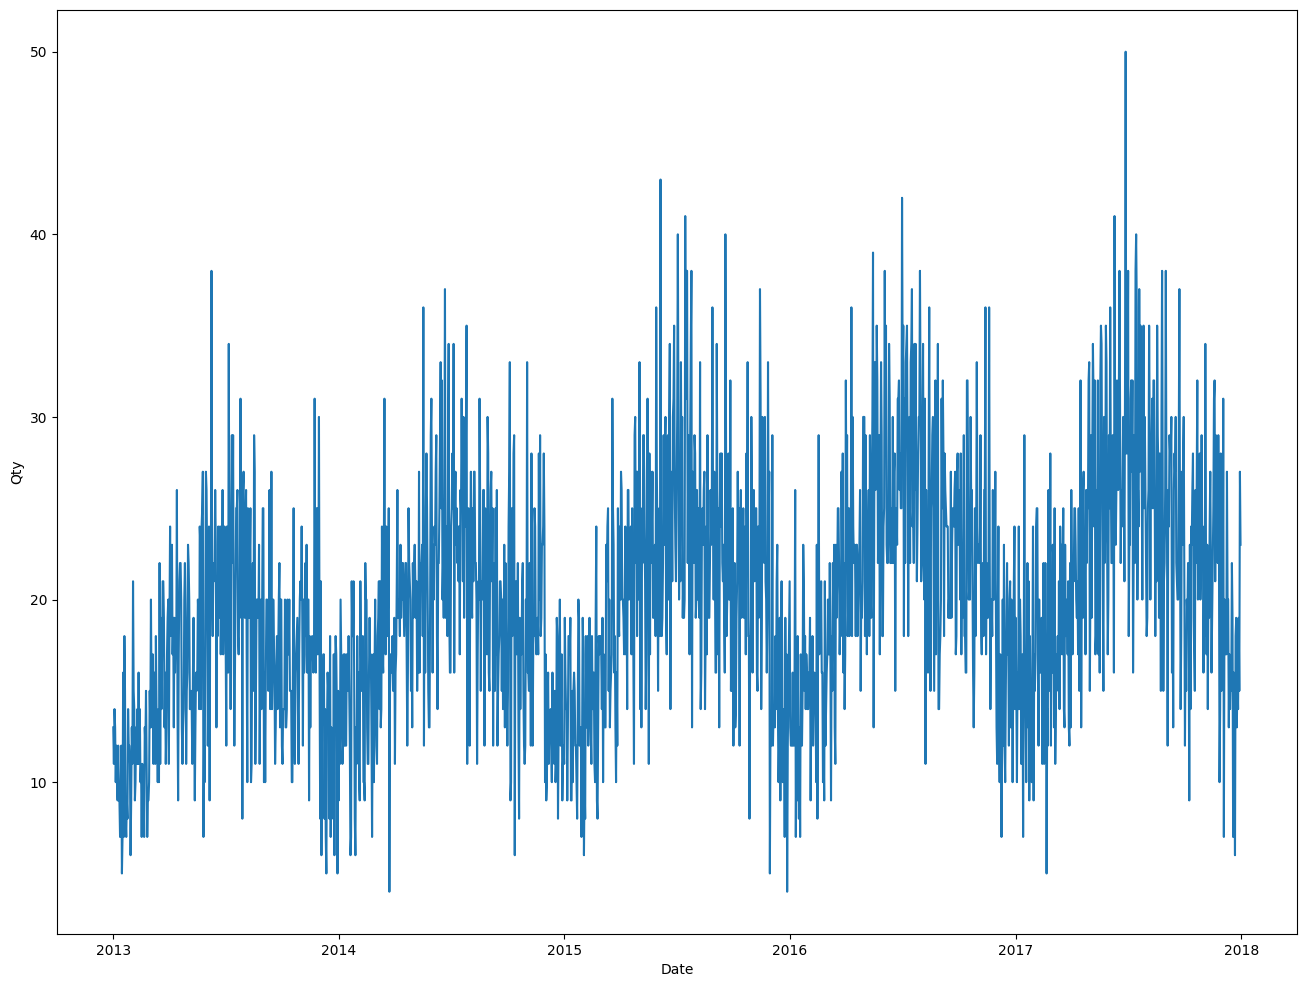

In [109]:
df = df.query('store==1 & item==1')
df = df.drop(["store", "item"], axis=1)
# test_df_item = test_df.query('store==1 & item==1')
plt.figure(figsize=(16, 12))
plt.plot(df['sales'])
plt.xlabel('Date')
plt.ylabel('Qty')
plt.show()

In [68]:
from typing import Tuple

def make_seq(data: np.ndarray, seq_size: int) -> Tuple[np.ndarray, np.ndarray]:
  """データをsequence_sizeに指定したサイズのシーケンスに分けてシーケンスとその答えをarrayで返す
  Args:
    data (np.ndarray): 入力データ
    sequence_size (int): シーケンスサイズ
  Returns:
    seq_arr: sequence_sizeに指定した数のシーケンスを格納するarray
    target_arr: シーケンスに対応する答えを格納するarray
  """

  num_data = len(data)
  seq_data = []
  target_data = []
  for i in range(num_data - seq_size):
      seq_data.append(data[i:i+seq_size])
      target_data.append(data[i+seq_size:i+seq_size+1])
  seq_arr = np.array(seq_data)
  target_arr = np.array(target_data)

  return seq_arr, target_arr


In [84]:
class MyModel(nn.Module):
  def __init__(self, hidden_size=100):
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = LSTM(input_size=1, hidden_size=self.hidden_size, batch_first=True)
    self.linear = Linear(self.hidden_size, 1)

  def forward(self, x):
    x, _ = self.lstm(x)
    x_last = x[-1]
    x = self.linear(x_last)

    return x


In [114]:
train = df.loc[:"2016-12-31"].values
test = df.loc["2017-01-01":].values

scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(train)
scaled_train_data = scaler.transform(train)
scaled_test_data = scaler.transform(test)

seq_length = 30
train_X, train_Y = make_seq(scaled_train_data, seq_length)
test_X, test_Y = make_seq(scaled_test_data, seq_length)

# テンソル変換してLSTMに入力するために軸を変更(シーケンス、バッチサイズ、入力次元)
tensor_train_X = torch.FloatTensor(train_X).permute(1, 0, 2)
tensor_train_Y = torch.FloatTensor(train_Y).permute(1, 0, 2)
tensor_test_X = torch.FloatTensor(test_X).permute(1, 0, 2)
# rmseを計算する時の形を合わせる
test_Y = test_Y.reshape(len(test_Y), 1)

In [112]:
model = MyModel(100)
criterion = MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [115]:
epochs = 100
losses = []

with tqdm(total=epochs, desc='Training', position=0) as pbar:
  for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(tensor_train_X)
    loss = criterion(output, tensor_train_Y)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    pbar.update()

Training:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 1431, 1])) that is different to the input size (torch.Size([1431, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training: 100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


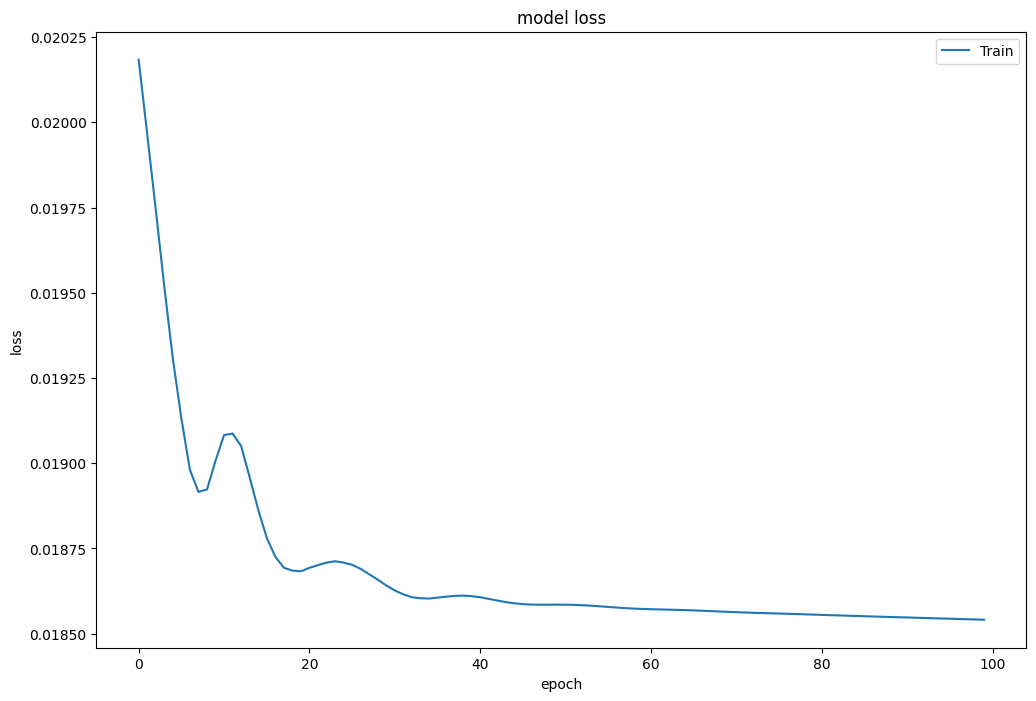

In [116]:
plt.figure(figsize=(12, 8))
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(losses)
plt.legend(["Train"])
plt.show()

In [117]:
predictions = model(tensor_test_X).detach().numpy()

In [118]:
rmse = mean_squared_error(test_Y, predictions, squared=False)
rmse

0.15437354054838648

<ipython-input-122-298f0aa98974>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = scaler.inverse_transform(predictions)


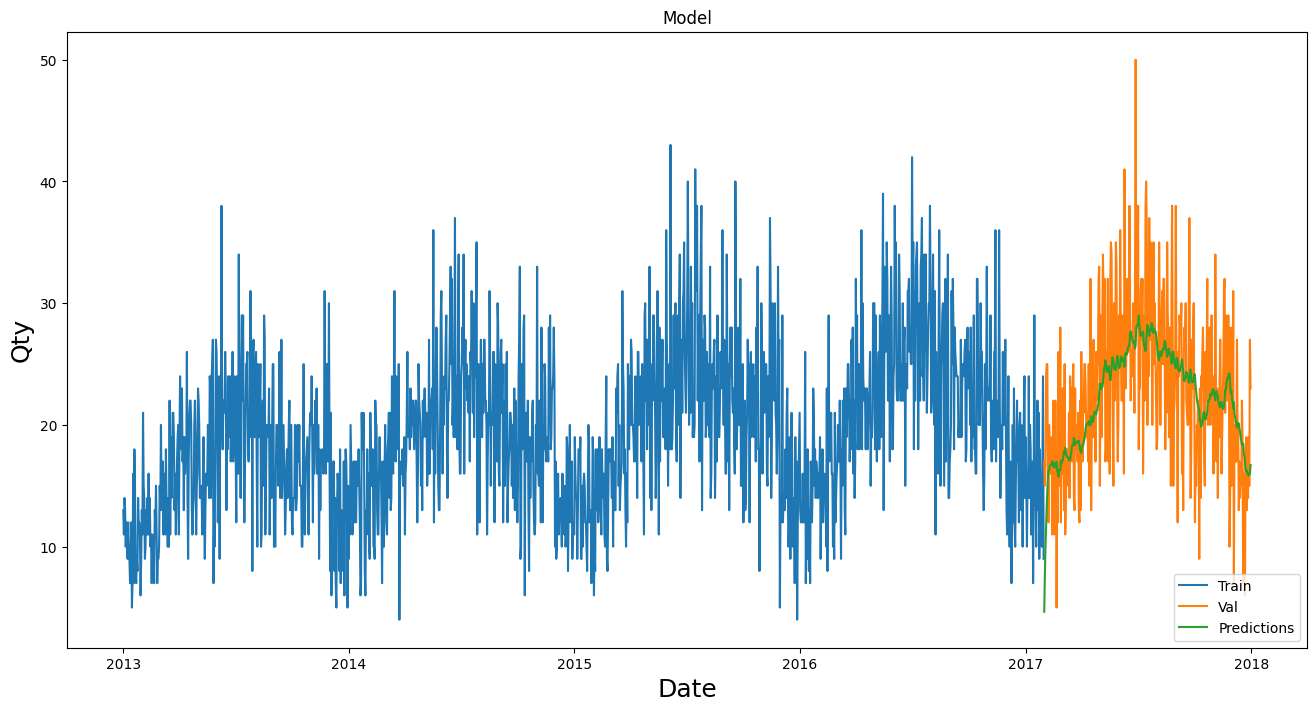

In [122]:
train = df.loc[:"2017-01-30"]
valid = df.loc["2017-01-31":]
valid['pred'] = scaler.inverse_transform(predictions)

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Qty', fontsize=18)
plt.plot(train['sales'])
# plt.legend(['Train', 'Test', 'Pred'], loc='lower right')
plt.plot(valid[['sales', 'pred']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()